In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
import ast
from technicalSignals import momentum,SMA,inBBands


In [2]:
# ========== GOOGLE SENTIMENT vs DICTIONARY  =================
#
# EXPERIMENT WITH TIMESTEP 1H
#
# Predict if the volume is higher respect to 
#

newsGoogle =  pd.read_csv('/home/simone/Desktop/NLFF/GoogleNL/Aggregated_1h_dataset/AAPL_googleSentPerTimestep.csv')
newsDict =  pd.read_csv('/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/AAPL.csv')

price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexesAAPL.csv')

price = price.rename(index=str, columns={"date": "DATE"})
newsGoogle = newsGoogle.rename(index=str, columns={"initTime": "DATE"})
newsDict = newsDict.rename(index=str, columns={"initTime": "DATE"})
newsGoogle = newsGoogle.drop(['Unnamed: 0'], axis=1)



newsGoogle['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsGoogle['DATE']]
newsDict['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsDict['DATE']]


# This datased is already GMT+0
price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
#newsGoogle['entSentVec'] = [ast.literal_eval(row) for row in newsGoogle['entSentVec']]

#Technical indicatoros:
price['mom_30'] = momentum(price, 30)
price['mom_50'] = momentum(price, 50)
price['mom_100'] = momentum(price, 100)
price['mom_150'] = momentum(price, 150)
price['SMA_30'] = SMA(price, 30)
price['SMA_50'] = SMA(price, 50)
price['SMA_100'] = SMA(price, 100)
price['SMA_150'] = SMA(price, 150)
price['in_BBands'] = inBBands(price)



#ALLIGNMENT GOOGLE SENTIMENT
initDate = newsGoogle['DATE'][0]
finalDate = newsGoogle['DATE'][len(newsGoogle)-1]
price.drop(price[price.DATE > finalDate].index, inplace=True)
price.drop(price[price.DATE < initDate].index, inplace=True)
price = price.reset_index(drop=True)

for data in newsGoogle['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsGoogle)

#ALLIGNMENT DICT SENTIMENT
newsDict.drop(newsDict[newsDict.DATE > finalDate].index, inplace=True)
newsDict.drop(newsDict[newsDict.DATE < initDate].index, inplace=True)
newsDict = newsDict.reset_index(drop=True)

for data in newsDict['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsDict)


technical_features = ['mom_30','mom_50','mom_100','mom_150','SMA_30','SMA_50','SMA_100','SMA_150','in_BBands']
# FEATURES GOOGLE
cols_google = list(newsGoogle.columns)
cols_google.remove('DATE')
sentiment = newsGoogle[cols_google]
X_google = sentiment
for window in [5,10,15,20,30,50]:
    temp = sentiment.rolling(window).mean()
    temp.columns = temp.columns +'_'+str(window)
    X_google = pd.concat([X_google, temp],axis=1)
X_google = pd.concat([X_google, price[technical_features]],axis=1)    
    
# FEATURES DICT
sentiment = newsDict.drop(['Unnamed: 0', 'DATE'], axis=1)
X_dict = sentiment
for window in [5,10,15,20,30,50]:
    temp = sentiment.rolling(window).mean()
    temp.columns = temp.columns +'_'+str(window)
    X_dict = pd.concat([X_dict, temp],axis=1)
X_dict = pd.concat([X_dict, price[technical_features]],axis=1)



TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
#X_dict.head()
print(X_dict.shape)
print(X_google.shape)

(1902, 65)
(3804, 870)


/home/simone/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


# comp:  5
trend:  -48   0
{(-48, 0): [0.5611510791366906], (-35, 0): [], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -35   0
{(-48, 0): [0.5611510791366906], (-35, 0): [0.4928571428571429], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -28   0
{(-48, 0): [0.5611510791366906], (-35, 0): [0.4928571428571429], (-28, 0): [0.4822064056939502], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -7   0
{(-48, 0): [0.5611510791366906], (-35, 0): [0.4928571428571429], (-28, 0): [0.4822064056939502], (-7, 0): [0.5369718309859155], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -1   0
{(-48, 0): [0.5611510791366906], (-35, 0): [0.4928571428571429], (-28, 0): [0.4822064056939502], (-7, 0): [0.5369718309859155], (-1, 0): [0.5157894736842106], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36)

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338], (-1, 0): [0.5157894736842106, 0.5], (1, 2): [0.4991212653778559, 0.4991212653778559], (1, 8): [0.5008818342151675, 0.5590828924162258], (1, 29): [0.44563279857397503, 0.4919786096256685], (1, 36): [0.4257602862254025, 0.552772808586762], (1, 50): [0.4648648648648649, 0.5495495495495496]}
trend:  -1   0
{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965], (1, 2): [0.4991212653778559, 0.4991212653778559], (1, 8): [0.50088

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615], (1, 8): [0.5008818342151675, 0.5590828924162258, 0.5855379188712522], (1, 29): [0.44563279857397503, 0.4919786096256685, 0.5311942959001783], (1, 36): [0.4257602862254025, 0.552772808586762, 0.554561717352415], (1, 50): [0.4648648648648649, 0.5495495495495496, 0.6072072072072072]}
trend:  1   8
{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.589285

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615], (1, 8): [0.5008818342151675, 0.5590828924162258, 0.5855379188712522, 0.6031746031746031], (1, 29): [0.44563279857397503, 0.4919786096256685, 0.5311942959001783, 0.5632798573975044], (1, 36): [0.4257602862254025, 0.552772808586762, 0.554561717352415, 0.5474060822898033], (1, 50): [0.4648648648648649, 0.5495495495495496, 0.6072072072072072, 0.5531531531531532]}
trend

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615, 0.5430579964850615], (1, 8): [0.5008818342151675, 0.5590828924162258, 0.5855379188712522, 0.6031746031746031, 0.6031746031746031], (1, 29): [0.44563279857397503, 0.4919786096256685, 0.5311942959001783, 0.5632798573975044, 0.5543672014260249], (1, 36): [0.4257602862254025, 0.552772808586762, 0.55456171735241

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615], (1, 8): [0.5008818342151675, 0.5590828924162258, 0.5855379188712522, 0.6031746031746031, 0.6031746031746031, 0.599647266313933], (1, 29): [0.44563279857397503, 0.4919786096256685, 0.5311942959001783, 0.5632798573975044, 0.55436

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714, 0.575], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615], (1, 8): [0.5008818342151675, 0.5590828924162258, 0.5855379188712522, 0.6031746031746031, 0.6031746031746031, 0.599647266

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714, 0.575, 0.5767857142857142], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615], (1, 8): [0.5008818342151675, 0.5590828924162258, 0.585537918

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714, 0.575, 0.5767857142857142], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338, 0.5334507042253521, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615, 0.5430579964850615], 

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714, 0.575, 0.5767857142857142, 0.5767857142857142], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338, 0.5334507042253521, 0.5334507042253521, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0.5430579964850615, 0

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714, 0.575, 0.5767857142857142, 0.5767857142857142], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338, 0.5334507042253521, 0.5334507042253521, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983], (1, 2): [0.4991212653778559, 0.4991212653778559, 0.5448154657293497, 0

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714, 0.575, 0.5767857142857142, 0.5767857142857142, 0.5767857142857142], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338, 0.5334507042253521, 0.5334507042253521, 0.5334507042253521, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.514035087

{(-48, 0): [0.5611510791366906, 0.5485611510791367, 0.552158273381295, 0.5503597122302158, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741, 0.5539568345323741], (-35, 0): [0.4928571428571429, 0.5446428571428571, 0.6089285714285714, 0.5892857142857143, 0.5714285714285714, 0.5714285714285714, 0.575, 0.5767857142857142, 0.5767857142857142, 0.5767857142857142], (-28, 0): [0.4822064056939502, 0.6779359430604982, 0.6067615658362989, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996, 0.5355871886120996], (-7, 0): [0.5369718309859155, 0.5475352112676056, 0.5352112676056338, 0.5316901408450704, 0.5334507042253521, 0.5352112676056338, 0.5334507042253521, 0.5334507042253521, 0.5334507042253521, 0.5334507042253521], (-1, 0): [0.5157894736842106, 0.5, 0.5280701754385965, 0.5105263157894737, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.5140350877192983, 0.514035087

<Figure size 432x288 with 0 Axes>

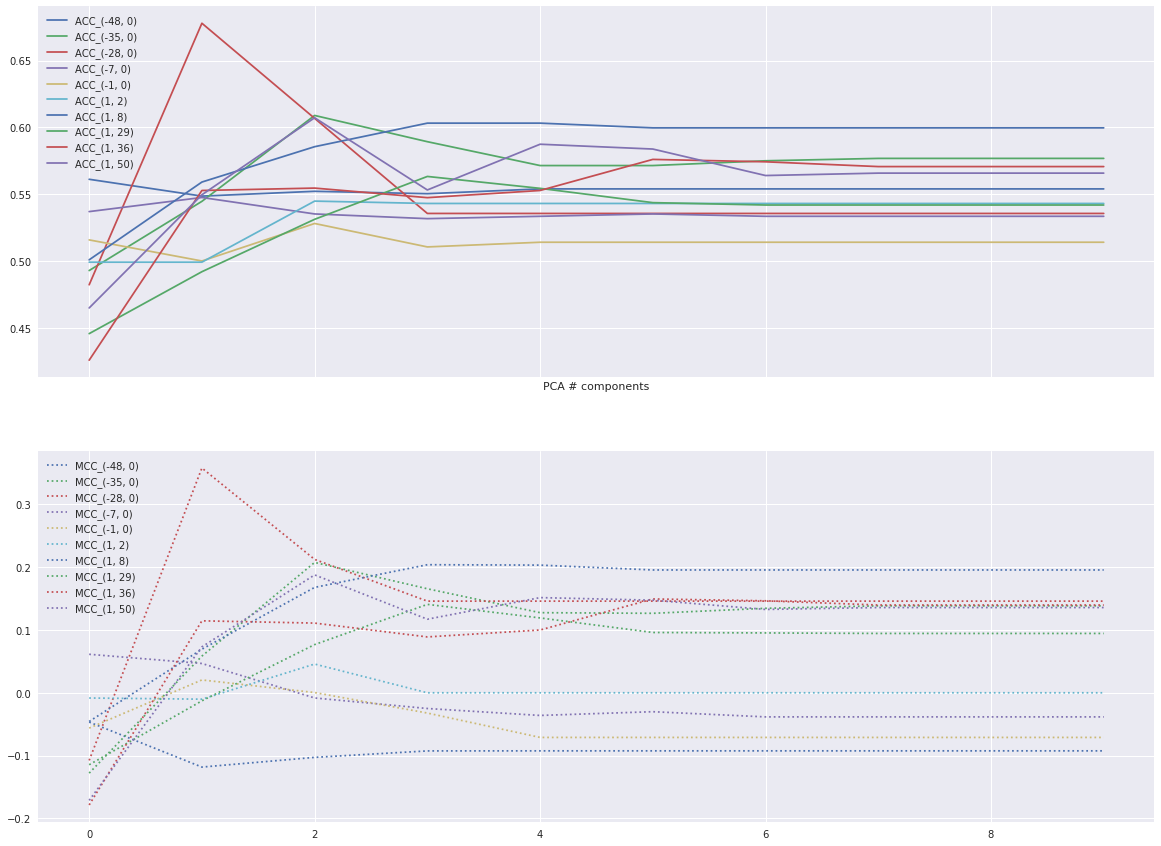

# comp:  5
trend:  -48   0
{(-48, 0): [0.789568345323741], (-35, 0): [], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -35   0
{(-48, 0): [0.789568345323741], (-35, 0): [0.7910714285714285], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -28   0
{(-48, 0): [0.789568345323741], (-35, 0): [0.7910714285714285], (-28, 0): [0.7544483985765125], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -7   0
{(-48, 0): [0.789568345323741], (-35, 0): [0.7910714285714285], (-28, 0): [0.7544483985765125], (-7, 0): [0.6197183098591549], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -1   0
{(-48, 0): [0.789568345323741], (-35, 0): [0.7910714285714285], (-28, 0): [0.7544483985765125], (-7, 0): [0.6197183098591549], (-1, 0): [0.531578947368421], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], 

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014], (-1, 0): [0.531578947368421, 0.5719298245614035], (1, 2): [0.5430579964850615, 0.5289982425307557], (1, 8): [0.544973544973545, 0.5220458553791887], (1, 29): [0.5953654188948306, 0.5490196078431373], (1, 36): [0.5295169946332737, 0.4865831842576029], (1, 50): [0.5621621621621622, 0.5333333333333333]}
trend:  -1   0
{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806], (1, 2): [0.5430579964850615, 0.52899824

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086], (1, 8): [0.544973544973545, 0.5220458553791887, 0.47971781305114636], (1, 29): [0.5953654188948306, 0.5490196078431373, 0.5668449197860963], (1, 36): [0.5295169946332737, 0.4865831842576029, 0.5438282647584973], (1, 50): [0.5621621621621622, 0.5333333333333333, 0.527927927927928]}
trend:  1   8
{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.833928571428

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086], (1, 8): [0.544973544973545, 0.5220458553791887, 0.47971781305114636, 0.49559082892416223], (1, 29): [0.5953654188948306, 0.5490196078431373, 0.5668449197860963, 0.5775401069518716], (1, 36): [0.5295169946332737, 0.4865831842576029, 0.5438282647584973, 0.5581395348837209], (1, 50): [0.5621621621621622, 0.5333333333333333, 0.527927927927928, 0.5207207207207207]}
tre

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086, 0.5377855887521968], (1, 8): [0.544973544973545, 0.5220458553791887, 0.47971781305114636, 0.49559082892416223, 0.48853615520282184], (1, 29): [0.5953654188948306, 0.5490196078431373, 0.5668449197860963, 0.5775401069518716, 0.5686274509803921], (1, 36): [0.5295169946332737, 0.4865831842576029, 0.54382826475

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086, 0.5377855887521968, 0.4797891036906854], (1, 8): [0.544973544973545, 0.5220458553791887, 0.47971781305114636, 0.49559082892416223, 0.48853615520282184, 0.49029982363315694], (1, 29): [0.5953654188948306, 0.5490196078431373, 0.5668449197860963, 0.5775401069518716, 0.5

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108, 0.9010791366906474], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142, 0.8142857142857143], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014, 0.8505338078291815], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029, 0.6901408450704225], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281, 0.6140350877192983], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086, 0.5377855887521968, 0.4797891036906854, 0.46397188049209137], (1, 8): [0.544973544973545, 0.5220458553791887, 0.47971781305114636, 0.49559082892416223, 0.4885361552028

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108, 0.9010791366906474, 0.89568345323741], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142, 0.8142857142857143, 0.8375], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014, 0.8505338078291815, 0.8861209964412812], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029, 0.6901408450704225], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281, 0.6140350877192983], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086, 0.5377855887521968, 0.4797891036906854, 0.46397188049209137], (1, 8): [0.544973544973545, 0.5220458553791887, 0.479717813

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108, 0.9010791366906474, 0.89568345323741], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142, 0.8142857142857143, 0.8375], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014, 0.8505338078291815, 0.8861209964412812], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029, 0.6901408450704225, 0.7200704225352113], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281, 0.6140350877192983, 0.5701754385964912], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086, 0.5377855887521968, 0.4797891036906854, 0.46397188049209137, 0.492091388400703], 

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108, 0.9010791366906474, 0.89568345323741, 0.8633093525179856], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142, 0.8142857142857143, 0.8375, 0.8214285714285714], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014, 0.8505338078291815, 0.8861209964412812, 0.8772241992882562], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029, 0.6901408450704225, 0.7200704225352113, 0.7517605633802817], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281, 0.6140350877192983, 0.5701754385964912], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0.5360281195079086, 0

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108, 0.9010791366906474, 0.89568345323741, 0.8633093525179856], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142, 0.8142857142857143, 0.8375, 0.8214285714285714], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014, 0.8505338078291815, 0.8861209964412812, 0.8772241992882562], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029, 0.6901408450704225, 0.7200704225352113, 0.7517605633802817], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281, 0.6140350877192983, 0.5701754385964912, 0.5912280701754385], (1, 2): [0.5430579964850615, 0.5289982425307557, 0.47451669595782076, 0

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108, 0.9010791366906474, 0.89568345323741, 0.8633093525179856, 0.8902877697841727], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142, 0.8142857142857143, 0.8375, 0.8214285714285714, 0.8428571428571429], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014, 0.8505338078291815, 0.8861209964412812, 0.8772241992882562, 0.8825622775800712], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029, 0.6901408450704225, 0.7200704225352113, 0.7517605633802817, 0.727112676056338], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281, 0.6140350877192983, 0.5701754385964912, 0.59122807017

{(-48, 0): [0.789568345323741, 0.7913669064748201, 0.8003597122302158, 0.8309352517985612, 0.8201438848920863, 0.8525179856115108, 0.9010791366906474, 0.89568345323741, 0.8633093525179856, 0.8902877697841727], (-35, 0): [0.7910714285714285, 0.7892857142857143, 0.8339285714285715, 0.8214285714285714, 0.825, 0.8267857142857142, 0.8142857142857143, 0.8375, 0.8214285714285714, 0.8428571428571429], (-28, 0): [0.7544483985765125, 0.7722419928825622, 0.8540925266903915, 0.8683274021352313, 0.8612099644128114, 0.8576512455516014, 0.8505338078291815, 0.8861209964412812, 0.8772241992882562, 0.8825622775800712], (-7, 0): [0.6197183098591549, 0.6285211267605634, 0.7306338028169014, 0.727112676056338, 0.7235915492957746, 0.7112676056338029, 0.6901408450704225, 0.7200704225352113, 0.7517605633802817, 0.727112676056338], (-1, 0): [0.531578947368421, 0.5719298245614035, 0.5543859649122806, 0.5807017543859649, 0.5596491228070175, 0.5754385964912281, 0.6140350877192983, 0.5701754385964912, 0.59122807017

<Figure size 432x288 with 0 Axes>

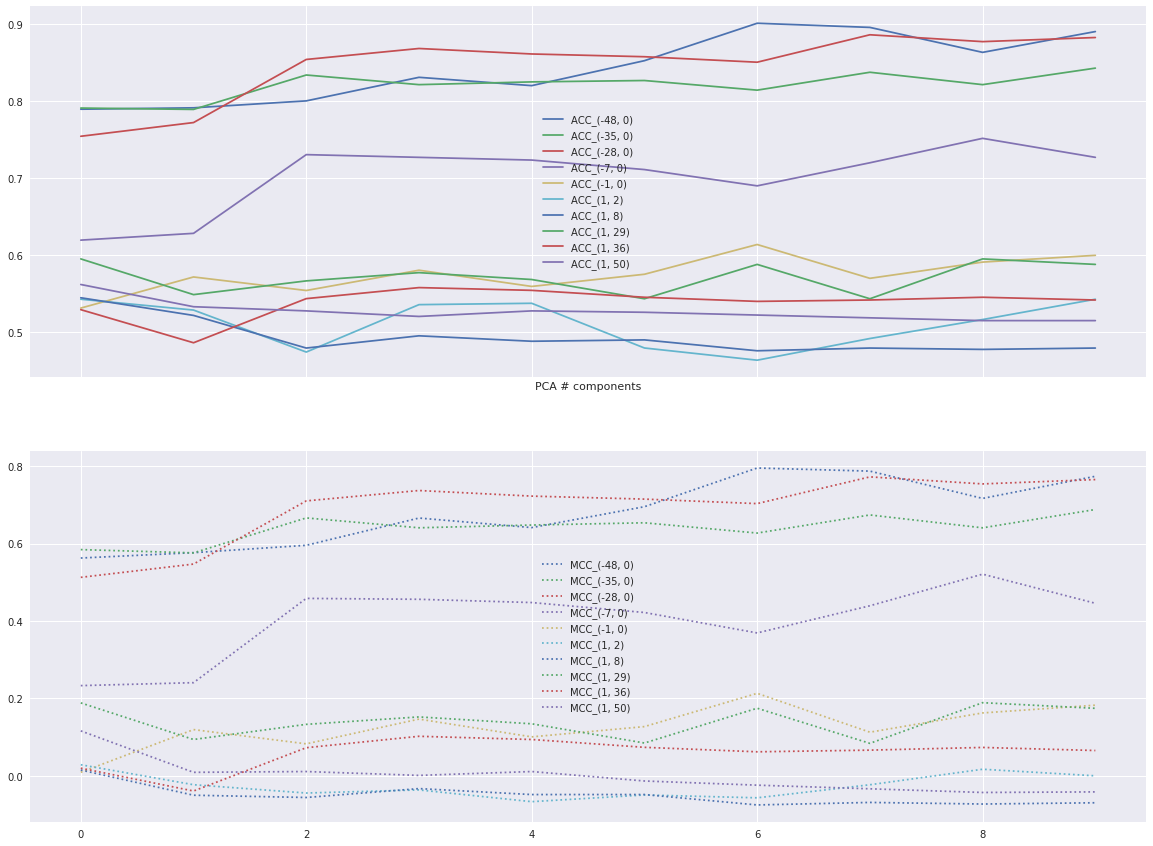

In [3]:
# ========== KSVM with PCA =================
from sklearn.decomposition import PCA
PCA_steps = 10

#NORMALIZATION:
min_max_scaler = preprocessing.MinMaxScaler()
X_google = np.nan_to_num(np.asarray(X_google, dtype=float))
X_google = np.asarray(min_max_scaler.fit_transform(X_google))

X_dict = np.nan_to_num(np.asarray(X_dict, dtype=float))
X_dict = np.asarray(min_max_scaler.fit_transform(X_dict))

for (X,ds) in [(X_google,'Google'),(X_dict,'Dict')]:
    MCCs = {(init, finish) : list() for (init, finish) in TREND_WINDOWs}
    ACCs = {(init, finish) : list() for (init, finish) in TREND_WINDOWs}
    for n_comp in np.linspace(5, X.shape[1], PCA_steps, endpoint=True, dtype = int):
        print('# comp: ',n_comp)
        X_PCA = PCA(n_components=n_comp).fit_transform(X)
        

        for (init, finish) in TREND_WINDOWs:
            print('trend: ',init,' ',finish)
            
            #CONSTRUCT LABELS
            x = list()
            y = list()

            for i in range(abs(init),len(price)-finish):
                cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
                s =np.sign(cumulative_return)
                if(s==-1):
                    y.append(0)
                else:
                    y.append(1)
                x.append(X_PCA[i])

            y = np.array(y)
            x = np.array(x)
            
            #DATASET DIVISION:
            train=0.7
            nt=math.ceil(len(x)*train)
            x_tv = x[:nt]
            y_tv = y[:nt]
            x_test = x[nt:]
            y_test = y[nt:]

            best_mcc = -float(np.inf)
            best_c = 0
            best_g = 0
            for c in np.logspace(-3,4,10):
                for g in np.logspace(-3,4,10):
                    trainpoint=math.floor(len(x_tv)*0.50)
                    dimval=math.floor(trainpoint*0.25)
                    endval=trainpoint+dimval
                    #Cross validation
                    cvMCC = 0
                    for i in range(0,4):
                        x_train=x_tv[0:trainpoint]
                        y_train=y_tv[0:trainpoint]
                        x_val=x_tv[trainpoint:endval]
                        y_val=y_tv[trainpoint:endval]
                        trainpoint=trainpoint+dimval
                        endval=endval+dimval
                        svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
                        svm_model.fit(x_train,y_train)
                        y_pred = svm_model.predict(x_val)
                        confmatrix = confusion_matrix(y_val, y_pred)
                        tn, fp, fn, tp = confmatrix.ravel()
                        denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                        mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
                        cvMCC += mcc/6

                    if(cvMCC > best_mcc):
                        best_mcc = cvMCC
                        best_c = c
                        best_g = g
                        

            svm_model = svm.SVC(kernel='rbf', C=best_c, gamma=best_g)
            svm_model.fit(x_tv,y_tv)
            acc = svm_model.score(x_test,y_test)
            y_pred = svm_model.predict(x_test)
            confmatrix = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = confmatrix.ravel()
            denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
            mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
            ACCs[(init, finish)].append(acc)
            MCCs[(init, finish)].append(mcc)
            print(ACCs)
            
    print(ds)
    plt.figure()
    f, axarr = plt.subplots(2, sharex=True, figsize=(20,15))
    for (init, finish) in MCCs.keys():
        axarr[1].plot(MCCs[(init, finish)], label='MCC_('+str(init)+', '+str(finish)+')')
        axarr[0].plot(ACCs[(init, finish)], label='ACC_('+str(init)+', '+str(finish)+')')
    axarr[0].set(xlabel='PCA # components')
    axarr[1].legend()
    axarr[0].legend()
    f.savefig('cumulativeReturnPredictions/onlyNews/PCA_'+str(ds)+'.jpg')
    plt.show()



In [ ]:
ACCs